# Compact representations of celebrity face images using deep fully convolutional autoencoders

In [35]:
from glob import glob
import math, munch, pickle

import torch as th
import numpy as np

import skimage as ski

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

In [2]:
filenames = glob('CelebA/Img/img_align_celeba/*.jpg')
len(filenames)

202599

((218, 178, 3), dtype('uint8'), 0, 255)

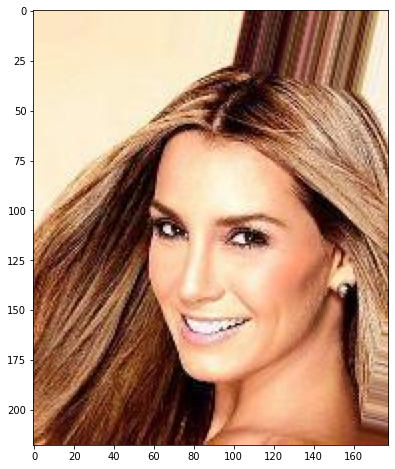

In [3]:
img = ski.io.imread(filenames[0])

plt.imshow(img);
img.shape, img.dtype, img.min(), img.max()

((218, 178, 3), dtype('float32'), 0.0, 1.0)

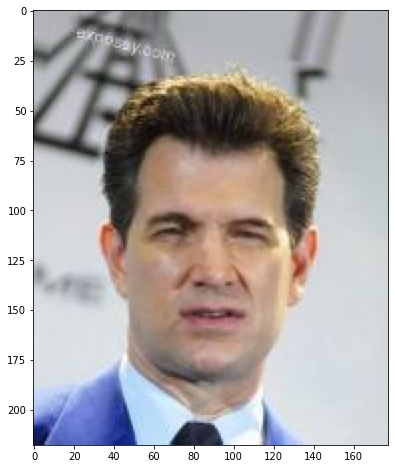

In [4]:
img = ski.img_as_float32(ski.io.imread(filenames[14]))

plt.imshow(img);
img.shape, img.dtype, img.min(), img.max()

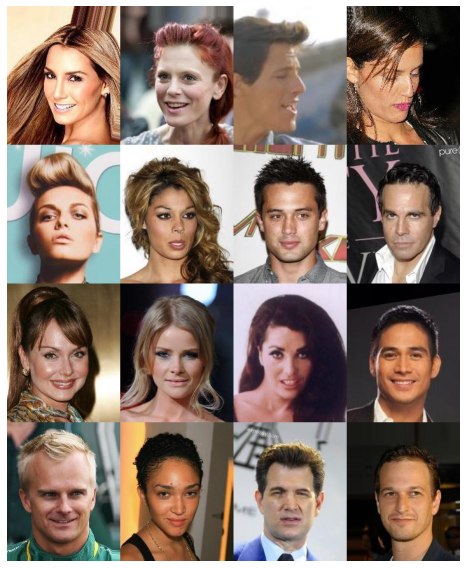

In [5]:
imgs = np.array([ski.img_as_float32(ski.io.imread(filename)) for filename in filenames[:16]])
montage = ski.util.montage(imgs, multichannel=True)

fig, ax = plt.subplots();
ax.imshow(montage);
ax.axis('off');
fig.tight_layout();

In [135]:
class ImageDataset(th.utils.data.Dataset):
    def __init__(self, filenames):
        self.filenames = list(filenames)
    
    def plot_montage(self, n=16):
        np_imgs = self[:n].permute(0, 2, 3, 1).numpy()
        montage = ski.util.montage(np_imgs, multichannel=True)
        fig, ax = plt.subplots()
        ax.imshow(montage)
        ax.axis('off')
        fig.tight_layout()
        
    def get(self, idx):
        np_img = ski.img_as_float32(ski.io.imread(self.filenames[idx]))
        th_img = th.as_tensor(np_img, dtype=th.float32).permute(2, 0, 1)
        return th_img
        
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.get(idx)
        
        elif isinstance(idx, slice):
            start, stop, stride = idx.indices(len(self))
            return th.stack([self.get(i) for i in range(start, stop, stride)])
            
        else:
            raise TypeError(f'indices must be integers or slices, not {type(idx).__name__}')
    
    def __len__(self):
        return len(self.filenames)

In [7]:
nfiles = len(filenames)
train_frac, valid_frac, test_frac = 0.8, 0.1, 0.1
ntrain = int(nfiles * train_frac)
nvalid = int(nfiles * valid_frac)
ntest = nfiles - ntrain - nvalid

nfiles, ntrain + nvalid + ntest, ntrain, nvalid, ntest

(202599, 202599, 162079, 20259, 20261)

In [8]:
np.random.shuffle(filenames)

train_filenames = filenames[:ntrain]
valid_filenames = filenames[ntrain:(ntrain+nvalid)]
test_filenames = filenames[(ntrain+nvalid):]

len(train_filenames), len(valid_filenames), len(test_filenames)

(162079, 20259, 20261)

In [136]:
train_data = ImageDataset(train_filenames)
valid_data = ImageDataset(valid_filenames)
test_data = ImageDataset(test_filenames)

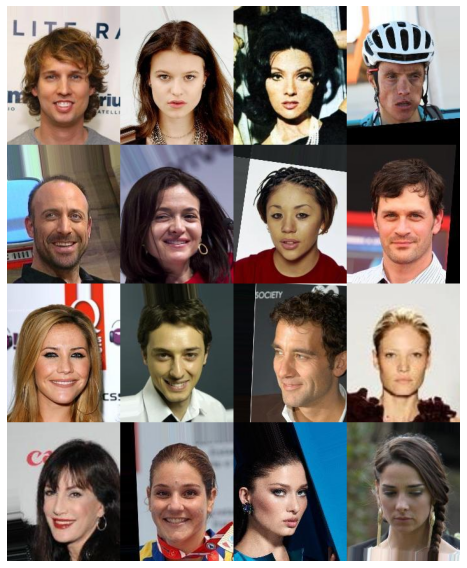

In [143]:
valid_data.plot_montage()

In [11]:
class EncodeBlock(th.nn.Module):
    def __init__(self, nchan, nfilt, kernel_size, stride, nhighway, transfer):
        super().__init__()
        
        self.batch_norm = th.nn.BatchNorm2d(nchan)
        
        self.highway = th.nn.Conv2d(
            nchan, nhighway,
            kernel_size=1,
            padding=0,
            stride=stride)
        
        self.conv = th.nn.Conv2d(
            nchan, nfilt,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            stride=stride)
        
        self.transfer = transfer()
        
    def forward(self, imgs):
        assert imgs.ndim == 4
        
        norm_imgs = self.batch_norm(imgs)
        highway_out = self.highway(norm_imgs)
        conv_out = self.transfer(self.conv(norm_imgs))

        return th.cat((highway_out, conv_out), dim=1)

In [12]:
class Encoder(th.nn.Module):
    def __init__(self, nchan, height, width, conv_specs, nhighway=8, transfer=th.nn.ReLU):
        super().__init__()
        
        self.nchan, self.height, self.width = nchan, height, width
        self.output_shapes = [(nchan, height, width)]
        self.conv_specs = conv_specs
        self.nhighway = nhighway
        
        convs = []
        layer_in, layer_out = None, self.nchan
        for nfilt, kernel_size, stride in self.conv_specs:
            layer_in, layer_out = layer_out, nfilt + nhighway
        
            convs.append(
                EncodeBlock(
                    layer_in, nfilt,
                    kernel_size=kernel_size,
                    stride=stride,
                    nhighway=self.nhighway,
                    transfer=transfer))
            
            height = math.ceil(height / stride)
            width = math.ceil(width / stride)
            self.output_shapes.append((layer_out, height, width))
            
        self.conv = th.nn.Sequential(*convs)
        
    def forward(self, imgs):
        assert isinstance(imgs, th.Tensor)                                                          
        assert imgs.ndim == 4                                                                 
        assert imgs.shape[1] == self.nchan                                                          
        assert imgs.shape[2] == self.height                                                         
        assert imgs.shape[3] == self.width                                                          
        batch_size = imgs.shape[0]                                                                  
                                                                                                    
        conv_out = self.conv(imgs)                                                        
        assert conv_out.ndim == 4                                                        
        assert conv_out.shape[0] == batch_size                                                 
        assert conv_out.shape[1] == self.output_shapes[-1][0] # nfilt
        assert conv_out.shape[2] == self.output_shapes[-1][1] # height
        assert conv_out.shape[3] == self.output_shapes[-1][2] # width
                                                                                                    
        codes = conv_out.reshape(batch_size, -1)                                      
        return codes

In [13]:
class DecodeBlock(th.nn.Module):
    def __init__(self, nchan, nfilt, kernel_size, stride, nhighway, transfer, output_shape):
        super().__init__()
        self.output_shape = output_shape
        
        self.batch_norm = th.nn.BatchNorm2d(nchan)
        
        self.highway = th.nn.ConvTranspose2d(
            nchan, nhighway,
            kernel_size=1,
            padding=0,
            stride=stride)
        
        self.conv = th.nn.ConvTranspose2d(
            nchan, nfilt,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            stride=stride)
        
        self.transfer = transfer()
        
    def forward(self, imgs):
        assert imgs.ndim == 4
        
        norm_imgs = self.batch_norm(imgs)
        highway_out = self.highway(norm_imgs, self.output_shape)
        conv_out = self.transfer(self.conv(norm_imgs, self.output_shape))

        return th.cat((highway_out, conv_out), dim=1)

In [14]:
class Decoder(th.nn.Module):
    def __init__(self, output_shapes, conv_specs, nhighway=8, transfer=th.nn.ReLU):
        super().__init__()
        
        self.output_shapes = output_shapes
        self.conv_specs = conv_specs
        self.nhighway = nhighway
        
        deconvs = []
        layer_in, layer_out = None, output_shapes[0][0]
        for i, (nfilt, kernel_size, stride) in enumerate(self.conv_specs):
            layer_in, layer_out = layer_out, nfilt + nhighway
        
            deconvs.append(
                DecodeBlock(
                    layer_in, nfilt,
                    kernel_size=kernel_size,
                    stride=stride,
                    nhighway=self.nhighway,
                    transfer=transfer,
                    output_shape=self.output_shapes[i+1][1:]))

        self.deconv = th.nn.Sequential(*deconvs)
        
        nchan, _height, _width = self.output_shapes[-1]
        self.readout = th.nn.Sequential(                                                            
            th.nn.BatchNorm2d(layer_out),                                                           
            th.nn.Conv2d(layer_out, nchan, kernel_size=1, padding=0))
    
    def forward(self, codes):
        assert isinstance(codes, th.Tensor)
        assert codes.ndim == 2
        batch_size = codes.shape[0]
                                                                                                    
        code_imgs = codes.reshape((batch_size,) + self.output_shapes[0])
        assert code_imgs.ndim == 4
        assert code_imgs.shape[0] == batch_size
        assert code_imgs.shape[1] == self.output_shapes[0][0] # nfilt
        assert code_imgs.shape[2] == self.output_shapes[0][1] # height
        assert code_imgs.shape[3] == self.output_shapes[0][2] # width

        deconv_out = self.deconv(code_imgs)                                                   
        assert deconv_out.ndim == 4
        assert deconv_out.shape[0] == batch_size
        assert deconv_out.shape[2] == self.output_shapes[-1][1] # height
        assert deconv_out.shape[3] == self.output_shapes[-1][2] # width
                                                                                                    
        imgs = self.readout(deconv_out)
        assert imgs.ndim == 4
        assert imgs.shape[0] == batch_size
        assert imgs.shape[1] == self.output_shapes[-1][0] # nchan
        assert imgs.shape[2] == self.output_shapes[-1][1] # height
        assert imgs.shape[3] == self.output_shapes[-1][2] # width
                                                                                                    
        return imgs

In [15]:
class Autoencoder(th.nn.Module):
    def __init__(self, nchan, height, width, conv_specs, nhighway=8, transfer=th.nn.ReLU):                  
        super().__init__()

        assert nchan > 0
        assert height > 0
        assert width > 0
        self.nchan, self.height, self.width = nchan, height, width

        assert nhighway > 0
        self.nhighway = nhighway
        
        assert isinstance(conv_specs, tuple)
        self.conv_specs = conv_specs

        assert issubclass(transfer, th.nn.Module)
        self.transfer = transfer
                                                                                            
        self.encoder = Encoder(
            nchan=self.nchan,
            height=self.height,
            width=self.width,
            conv_specs=self.conv_specs,
            nhighway=self.nhighway,
            transfer=self.transfer)

        rev_conv_specs = tuple(reversed(self.conv_specs))
        rev_output_shapes = tuple(reversed(self.encoder.output_shapes))
                                                                                                    
        self.decoder = Decoder(
            output_shapes=rev_output_shapes,
            conv_specs=rev_conv_specs,
            nhighway=nhighway,
            transfer=transfer)
                                                                                                    
        self.sigmoid = th.nn.Sigmoid()                                                              
                                                                                                    
    def forward(self, imgs):                                                                        
        return self.decoder(self.encoder(imgs))                                                     
                                                                                                    
    def recon(self, imgs):                                                                          
        return self.sigmoid(self(imgs)).detach()

In [16]:
def train(model, train_data, valid_data, max_epochs=350, stop_epochs=20,
          learning_rate=0.00175, learning_rate_decay=0.998, clip_norm=6,
          batch_size=64, load_workers=12, use_gpu=True):

        train_loader = th.utils.data.DataLoader(
            train_data,
            batch_size=batch_size,
            pin_memory=use_gpu,
            num_workers=load_workers,
            shuffle=True)

        valid_loader = th.utils.data.DataLoader(
            valid_data,
            batch_size=batch_size,
            pin_memory=use_gpu,
            num_workers=load_workers,
            shuffle=False)

        if use_gpu:
            model.cuda()

        print_batch_skip = 100
        loss_func = th.nn.BCEWithLogitsLoss(reduction='mean')

        train_losses = []
        valid_losses = []

        best_train_loss = float('inf')
        best_valid_loss = float('inf')
        best_epoch = 0
        best_state = None

        parameters = list(filter(lambda param: param.requires_grad, model.parameters()))
        
        for epoch in range(max_epochs):                                                                                                    
            # initialize the optimizer
            optimizer = th.optim.Adam(parameters, lr=learning_rate)

            # enter training mode
            model.train()

            # training pass
            epoch_train_losses = []
            for i, imgs in enumerate(train_loader):
                optimizer.zero_grad()

                if use_gpu:
                    imgs = imgs.cuda()

                recons = model(imgs)
                loss = loss_func(recons, imgs)

                loss_f = loss.item()
                epoch_train_losses.append(loss_f)
                if i % print_batch_skip == 0:
                    print(f'T {epoch} {i} {learning_rate:.6f} {loss_f:.6f}')

                loss.backward()

                if clip_norm is not None:
                    th.nn.utils.clip_grad_norm_(parameters, clip_norm)

                optimizer.step()

            train_losses.append(np.mean(epoch_train_losses))

            # back to evaluation mode
            model.eval()

            # validation loss
            with th.no_grad():
                epoch_valid_losses = []
                for i, imgs in enumerate(valid_loader):
                    if use_gpu:
                        imgs = imgs.cuda()

                    recons = model(imgs)
                    loss = loss_func(recons, imgs)

                    loss_f = loss.item()
                    epoch_valid_losses.append(loss_f)
                    if i % print_batch_skip == 0:
                        print(f'V {epoch} {i} {learning_rate:.6f} {loss_f:.6f}')

            valid_losses.append(np.mean(epoch_valid_losses))
            
            print('train loss:')
            print(train_losses[-1])
            print(train_losses[-4:])
            print('valid loss:')
            print(valid_losses[-1])
            print(valid_losses[-4:])
            print('best epoch:', best_epoch)
            print('=======')

            if valid_losses[-1] < best_valid_loss:
                best_train_loss = train_losses[-1]
                best_valid_loss = valid_losses[-1]
                best_epoch = epoch
                best_state = model.state_dict()
                print(f'best state found at epoch {epoch}')

            if (best_epoch + stop_epochs) <= epoch:
                print(f'terminating after {stop_epochs} of no improvement')
                break

            learning_rate *= learning_rate_decay

        if best_state is None:
            raise RuntimeError('best state not set!')

        model.load_state_dict(best_state)

        if use_gpu:
            model.cpu()

        return munch.munchify({
            'train_losses': train_losses,
            'valid_losses': valid_losses,
            'best_train_loss': best_train_loss,
            'best_valid_loss': best_valid_loss,
            'best_epoch': best_epoch,
        })

In [17]:
first_image = train_data[0]

autoencoder = Autoencoder(
    nchan=first_image.shape[0],
    height=first_image.shape[1],
    width=first_image.shape[2],
    conv_specs=((24, 19, 2), (32, 15, 2), (40, 11, 2),),
    nhighway=8)

autoencoder

Autoencoder(
  (encoder): Encoder(
    (conv): Sequential(
      (0): EncodeBlock(
        (batch_norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (highway): Conv2d(3, 8, kernel_size=(1, 1), stride=(2, 2))
        (conv): Conv2d(3, 24, kernel_size=(19, 19), stride=(2, 2), padding=(9, 9))
        (transfer): ReLU()
      )
      (1): EncodeBlock(
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (highway): Conv2d(32, 8, kernel_size=(1, 1), stride=(2, 2))
        (conv): Conv2d(32, 32, kernel_size=(15, 15), stride=(2, 2), padding=(7, 7))
        (transfer): ReLU()
      )
      (2): EncodeBlock(
        (batch_norm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (highway): Conv2d(40, 8, kernel_size=(1, 1), stride=(2, 2))
        (conv): Conv2d(40, 40, kernel_size=(11, 11), stride=(2, 2), padding=(5, 5))
        (transfer): ReLU()
      )
    )

In [18]:
sum(p.nelement() for p in autoencoder.parameters())

1376985

In [19]:
first_image.shape, first_image.shape[0] * first_image.shape[1] * first_image.shape[2]

(torch.Size([3, 218, 178]), 116412)

In [20]:
autoencoder.encoder(first_image[None, ...]).shape

torch.Size([1, 30912])

In [21]:
autoencoder.encoder.output_shapes

[(3, 218, 178), (32, 109, 89), (40, 55, 45), (48, 28, 23)]

In [22]:
autoencoder(first_image[None, ...]).shape, first_image.shape

(torch.Size([1, 3, 218, 178]), torch.Size([3, 218, 178]))

In [23]:
recon = autoencoder.recon(first_image[None, ...])
recon.min(), recon.max()

(tensor(0.0263), tensor(0.9858))

In [24]:
train_result = train(autoencoder, train_data, valid_data, max_epochs=50, batch_size=256)

T 0 0 0.001750 0.731082
T 0 100 0.001750 0.485828
T 0 200 0.001750 0.476257
T 0 300 0.001750 0.479567
T 0 400 0.001750 0.475123
T 0 500 0.001750 0.481652
T 0 600 0.001750 0.474856
V 0 0 0.001750 0.478986
train loss:
0.485830673801034
[0.485830673801034]
valid loss:
0.4801433954387903
[0.4801433954387903]
best epoch: 0
best state found at epoch 0
T 1 0 0.001747 0.478155
T 1 100 0.001747 0.477523
T 1 200 0.001747 0.473404
T 1 300 0.001747 0.487483
T 1 400 0.001747 0.478053
T 1 500 0.001747 0.480274
T 1 600 0.001747 0.471065
V 1 0 0.001747 0.475289
train loss:
0.47696849261924673
[0.485830673801034, 0.47696849261924673]
valid loss:
0.47636683508753774
[0.4801433954387903, 0.47636683508753774]
best epoch: 1
best state found at epoch 1
T 2 0 0.001743 0.481218
T 2 100 0.001743 0.483926
T 2 200 0.001743 0.478558
T 2 300 0.001743 0.481686
T 2 400 0.001743 0.467465
T 2 500 0.001743 0.477426
T 2 600 0.001743 0.473092
V 2 0 0.001743 0.474015
train loss:
0.47486363205623927
[0.485830673801034, 0.4

T 18 0 0.001688 0.470699
T 18 100 0.001688 0.473404
T 18 200 0.001688 0.472255
T 18 300 0.001688 0.476851
T 18 400 0.001688 0.473842
T 18 500 0.001688 0.464108
T 18 600 0.001688 0.471469
V 18 0 0.001688 0.471205
train loss:
0.4715021081057257
[0.47168578301506464, 0.47157433774757085, 0.47151453304177954, 0.4715021081057257]
valid loss:
0.4722282513976097
[0.472356728464365, 0.47252481430768967, 0.4725900046527386, 0.4722282513976097]
best epoch: 18
best state found at epoch 18
T 19 0 0.001685 0.469652
T 19 100 0.001685 0.467343
T 19 200 0.001685 0.475081
T 19 300 0.001685 0.472970
T 19 400 0.001685 0.471548
T 19 500 0.001685 0.469952
T 19 600 0.001685 0.467141
V 19 0 0.001685 0.471272
train loss:
0.47145793241469264
[0.47157433774757085, 0.47151453304177954, 0.4715021081057257, 0.47145793241469264]
valid loss:
0.47229549288749695
[0.47252481430768967, 0.4725900046527386, 0.4722282513976097, 0.47229549288749695]
best epoch: 19
T 20 0 0.001681 0.472683
T 20 100 0.001681 0.473122
T 20 20

V 35 0 0.001632 0.470957
train loss:
0.47112469793494194
[0.471074751592961, 0.47108332516643153, 0.47106668578713473, 0.47112469793494194]
valid loss:
0.47197090163826944
[0.4720008511096239, 0.47194753028452396, 0.4720348998904228, 0.47197090163826944]
best epoch: 35
T 36 0 0.001628 0.467950
T 36 100 0.001628 0.473807
T 36 200 0.001628 0.472788
T 36 300 0.001628 0.474626
T 36 400 0.001628 0.458781
T 36 500 0.001628 0.469773
T 36 600 0.001628 0.481759
V 36 0 0.001628 0.471074
train loss:
0.4711318023573337
[0.47108332516643153, 0.47106668578713473, 0.47112469793494194, 0.4711318023573337]
valid loss:
0.47208387069404123
[0.47194753028452396, 0.4720348998904228, 0.47197090163826944, 0.47208387069404123]
best epoch: 36
T 37 0 0.001625 0.466996
T 37 100 0.001625 0.471388
T 37 200 0.001625 0.469617
T 37 300 0.001625 0.476837
T 37 400 0.001625 0.475765
T 37 500 0.001625 0.472864
T 37 600 0.001625 0.469123
V 37 0 0.001625 0.470905
train loss:
0.4710009685638199
[0.47106668578713473, 0.47112

In [36]:
with open('autoencoder.pkl', mode='wb') as fh:                                                  
    th.save(autoencoder.state_dict(), fh)

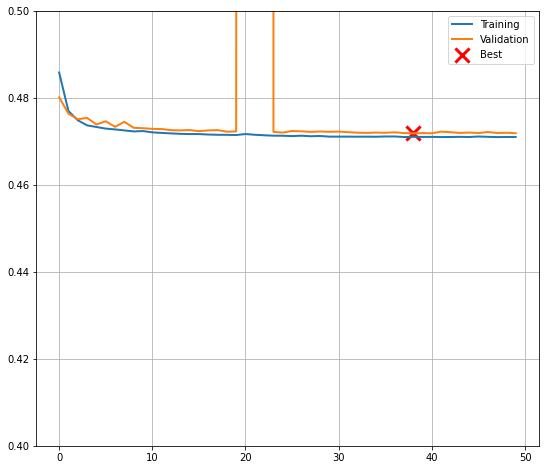

In [33]:
fig_loss = plt.figure()
ax_loss = fig_loss.add_subplot(1, 1, 1)
ax_loss.plot(train_result.train_losses, linewidth=2, label='Training')
ax_loss.plot(train_result.valid_losses, linewidth=2, label='Validation')
ax_loss.scatter(
    (train_result.best_epoch,), (train_result.best_valid_loss,),
    linewidth=3, s=200, marker='x', color='red', label='Best')
ax_loss.set_ylim((0.4, 0.5));
ax_loss.legend()
#ax_loss.autoscale(tight=True)
ax_loss.grid();

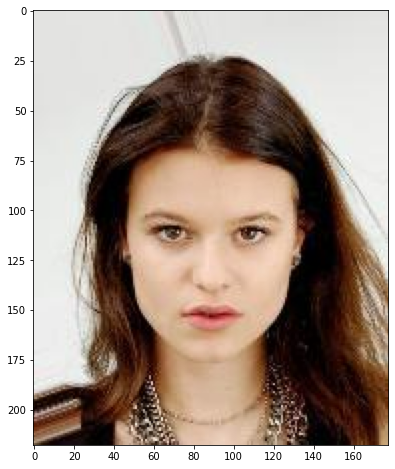

In [156]:
first_image = valid_data[1]
plt.imshow(first_image.permute(1, 2, 0));

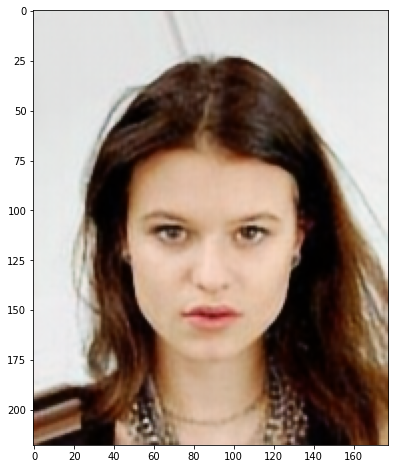

In [157]:
recon = autoencoder.recon(first_image[None, ...])

plt.imshow(recon.squeeze(0).permute(1, 2, 0));

In [150]:
def latent_interpolation(data, nrow=4, ninterp=6):
    fig = plt.figure()
    axs = []

    for row in range(nrow):
        img_idx = row
        first_image = data[img_idx]
        second_image = data[img_idx + nrow]

        first_latent = autoencoder.encoder(first_image[None, ...])
        second_latent = autoencoder.encoder(second_image[None, ...])

        for col in range(ninterp):
            interp_frac = col / float(ninterp - 1)
            interp_latent = interp_frac * first_latent + (1.0 - interp_frac) * second_latent

            decoded = th.sigmoid(autoencoder.decoder(interp_latent)).detach()
            np_decoded = decoded.squeeze(0).permute(1, 2, 0).numpy()

            ax = fig.add_subplot(nrow, ninterp, row*ninterp + col + 1)
            ax.imshow(np_decoded)
            ax.axis('off')
            axs.append(ax)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)

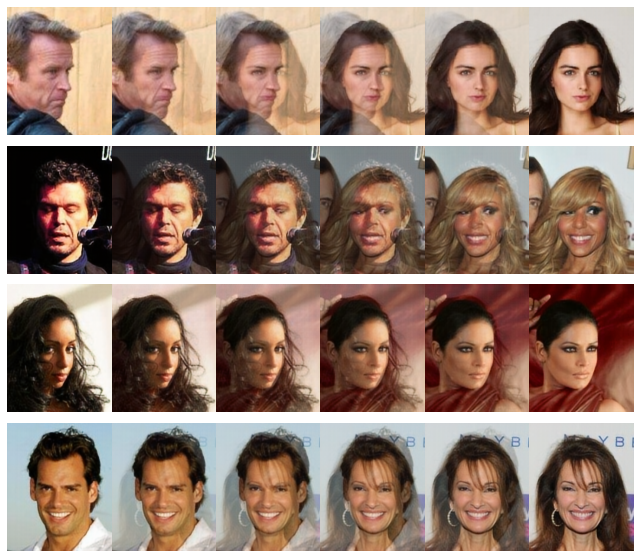

In [151]:
latent_interpolation(train_data);

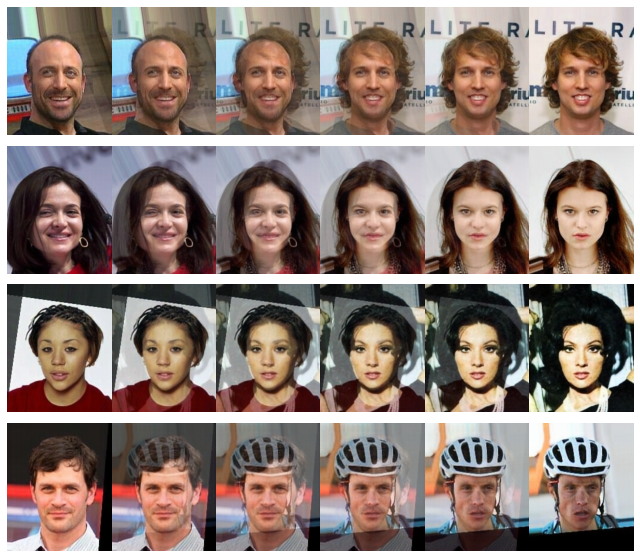

In [152]:
latent_interpolation(valid_data);

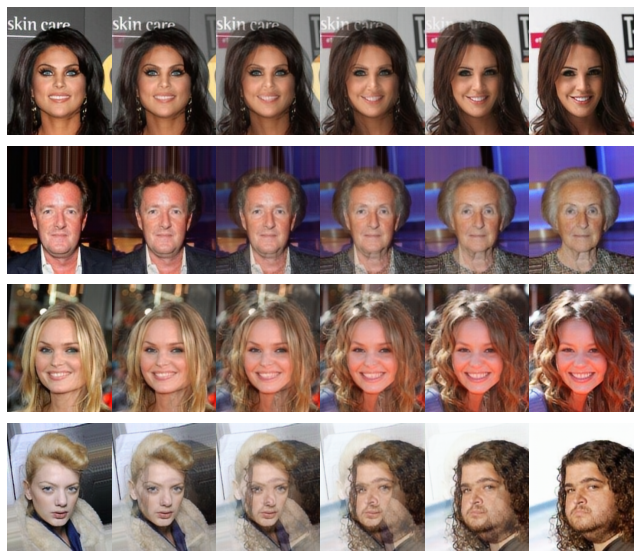

In [153]:
latent_interpolation(test_data);